# Bayesian Optimization with BoTorch

## 0. Imports

In [84]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import warnings
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.test_functions.synthetic import StyblinskiTang
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim.optimize import optimize_acqf
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generating Data

In [149]:
# Generate noisy data
stytang = StyblinskiTang(dim=2)
sigma_n = 0.1
train_x = -10 * torch.rand(10,1) + 5
train_y = -stytang(train_x).unsqueeze(1) + sigma_n * torch.randn_like(train_x)
best_observed_value = train_y.max().item()
print(train_y)

tensor([[  9.5669],
        [ 36.1003],
        [-73.0597],
        [  8.0663],
        [ 20.1201],
        [  4.2152],
        [-63.7762],
        [ 32.2072],
        [  0.9887],
        [  0.4118]])


## 2. Initialize GP Model 

In [153]:
# Initialize a GP model and the MLL
model = SingleTaskGP(train_X=train_x, train_Y=train_y)
ei_mll = ExactMarginalLogLikelihood(model.likelihood, model)

## 3. BO Loop

In [154]:
warnings.filterwarnings("ignore")

# To keep track of model and best observed value every 25 iterations
models = []
best_observed_xs = []
best_observed_values = []

# Run 100 iterations of BayesOpt with EI
for i in range(100):
    # Fit the model and compute logEI
    fit_gpytorch_model(ei_mll)
    logEI = LogExpectedImprovement(model, best_f=best_observed_value)
    
    # Optimize the acquisition function and get new candidate
    candidate, _ = optimize_acqf(
        acq_function=logEI,
        bounds=torch.tensor([[0.0], [1.0]]),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )

    # Add the new candidate and noisy function value to the training data
    new_y = stytang(candidate) + sigma_n * torch.randn_like(candidate)
    train_x = torch.cat([train_x, candidate])
    train_y = torch.cat([train_y, new_y])

    # Update the best observed value
    best_observed_value = train_y.max().item()

    # Update the model and the best observed value
    state_dict = model.state_dict()
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    ei_mll = ExactMarginalLogLikelihood(model.likelihood, model)
    model.load_state_dict(state_dict)
    
    # Keep track of the model and best observed every 25 iterations to plot later
    if (i + 1) % 25 == 0:
        print(i)
        print("here")
        models.append(model)
        best_observed_xs.append(train_x[train_y.argmax()])
        best_observed_values.append(best_observed_value)

24
here
49
here
74
here
99
here


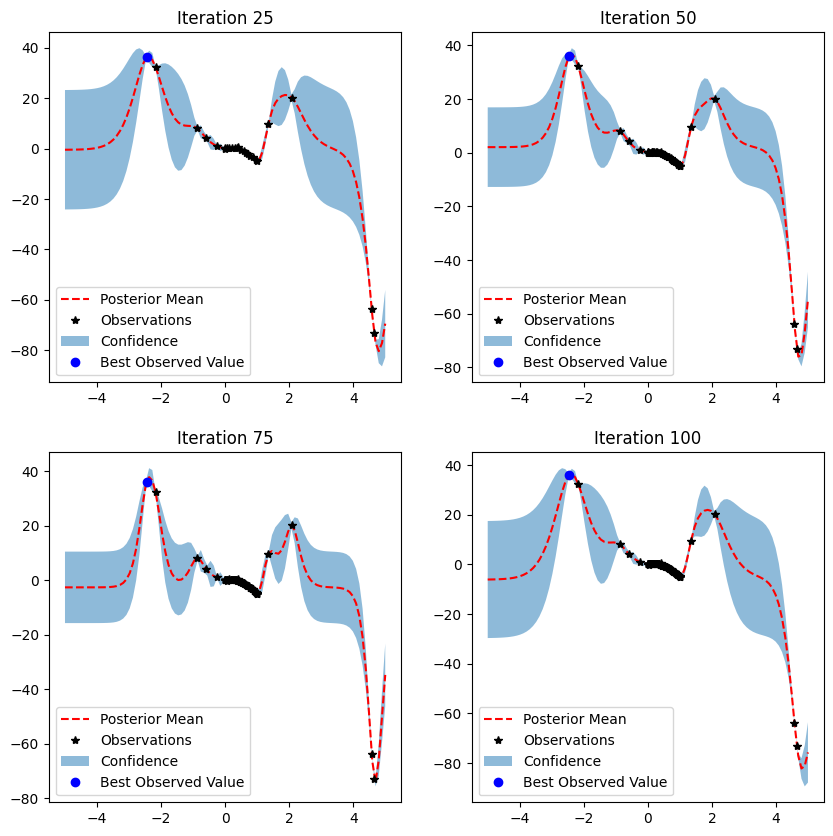

In [152]:
# Plot progress after each 25 iterations
test_x = torch.linspace(-5, 5, 100)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

with torch.no_grad():
    for i in range(2):
        for j in range(2):
            # Index of the model to plot
            idx = i * 2 + j

            # Get the model and its posterior
            model_ij = models[idx]
            posterior = model_ij.posterior(test_x)
            lower, upper = posterior.mvn.confidence_region()

            # Plot the model with errors bars and best observed value
            axs[i,j].plot(test_x.numpy(), posterior.mean.numpy(), 'r--', label='Posterior Mean')
            axs[i,j].plot(train_x[:(idx+1)*25].numpy(), train_y[:(idx+1)*25].numpy(), 'k*', label='Observations')
            axs[i,j].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
            axs[i,j].plot(np.array(best_observed_xs[idx]), np.array(best_observed_values[idx]), 'bo', label='Best Observed Value')
            axs[i,j].set_title(f'Iteration {(idx+1)*25}')
            axs[i,j].legend()

plt.show()